r mod 7 = 0  →  a_r = 0.5 × 3 = 0
r mod 5 = 4  →  b_r = 0.3 × (1 + 4) = 1.5


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
df = pd.read_csv("data.csv", encoding="latin1")
df.head()


/tmp/ipython-input-3885977855.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin1")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [ ]:
x = df["no2"].dropna().values
print("Number of samples:", len(x))


Number of samples: 419509


In [ ]:
a_r = 0
b_r = 1.5

z = x + a_r * np.sin(b_r * x)
z = z.reshape(-1, 1)


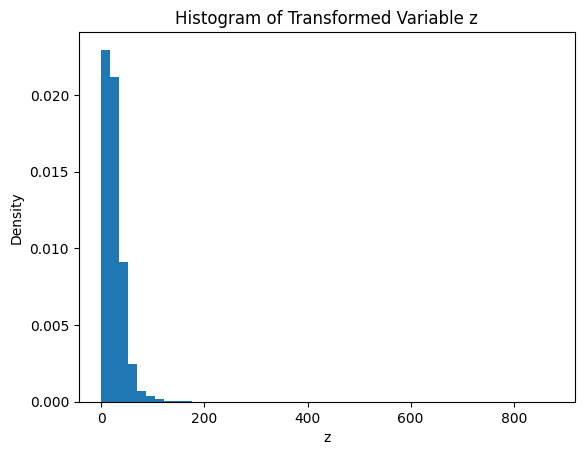

In [ ]:
plt.hist(z, bins=50, density=True)
plt.xlabel("z")
plt.ylabel("Density")
plt.title("Histogram of Transformed Variable z")
plt.show()


In [ ]:
z_tensor = torch.tensor(z, dtype=torch.float32)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.001)
optimizer_D = optim.Adam(D.parameters(), lr=0.001)


In [ ]:
epochs = 15000
batch_size = 128


In [ ]:
for epoch in range(epochs):
    idx = np.random.randint(0, len(z_tensor), batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # ---- Train Discriminator ----
    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    loss_real = criterion(D(real_samples), real_labels)
    loss_fake = criterion(D(fake_samples.detach()), fake_labels)
    loss_D = loss_real + loss_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # ---- Train Generator ----
    noise = torch.randn(batch_size, 1)
    generated = G(noise)
    loss_G = criterion(D(generated), real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch 0 | D Loss: 1.3540 | G Loss: 0.7282
Epoch 500 | D Loss: 1.3691 | G Loss: 0.6521
Epoch 1000 | D Loss: 1.3830 | G Loss: 0.7102
Epoch 1500 | D Loss: 1.3914 | G Loss: 0.6570
Epoch 2000 | D Loss: 1.3812 | G Loss: 0.6952
Epoch 2500 | D Loss: 1.3806 | G Loss: 0.6736
Epoch 3000 | D Loss: 1.3846 | G Loss: 0.6867
Epoch 3500 | D Loss: 1.3880 | G Loss: 0.6778
Epoch 4000 | D Loss: 1.3829 | G Loss: 0.6720
Epoch 4500 | D Loss: 1.3874 | G Loss: 0.6708
Epoch 5000 | D Loss: 1.5783 | G Loss: 0.6196
Epoch 5500 | D Loss: 1.3886 | G Loss: 0.7501
Epoch 6000 | D Loss: 1.3686 | G Loss: 0.7180
Epoch 6500 | D Loss: 1.3851 | G Loss: 0.6832
Epoch 7000 | D Loss: 1.3831 | G Loss: 0.7266
Epoch 7500 | D Loss: 1.3836 | G Loss: 0.6297
Epoch 8000 | D Loss: 1.3803 | G Loss: 0.6888
Epoch 8500 | D Loss: 1.3906 | G Loss: 0.7410
Epoch 9000 | D Loss: 1.3887 | G Loss: 0.6712
Epoch 9500 | D Loss: 1.3872 | G Loss: 0.6729
Epoch 10000 | D Loss: 1.3853 | G Loss: 0.7550
Epoch 10500 | D Loss: 1.3860 | G Loss: 0.6501
Epoch 11000 

In [ ]:
with torch.no_grad():
    z_fake = G(torch.randn(10000, 1)).numpy()


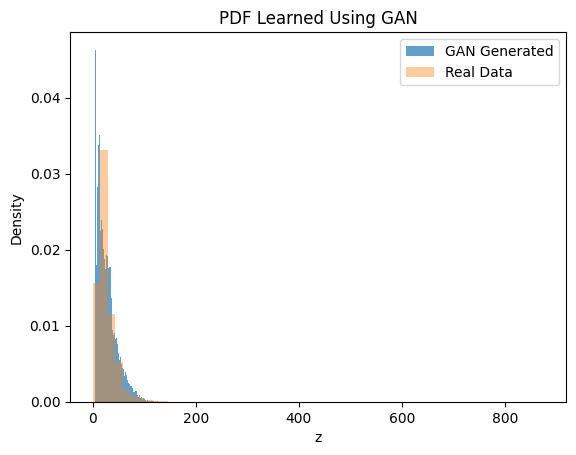

In [ ]:
plt.hist(z_fake, bins=60, density=True, alpha=0.7, label="GAN Generated")
plt.hist(z, bins=60, density=True, alpha=0.4, label="Real Data")
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Learned Using GAN")
plt.legend()
plt.show()


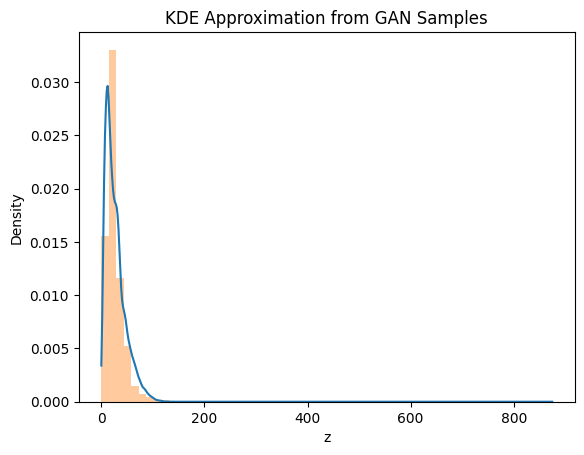

In [ ]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(z_fake.flatten())
z_vals = np.linspace(z.min(), z.max(), 500)

plt.plot(z_vals, kde(z_vals))
plt.hist(z, bins=60, density=True, alpha=0.4)
plt.title("KDE Approximation from GAN Samples")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()


In [ ]:
print("FINAL SUBMISSION DETAILS")
print("Roll Number: 102316004")
print("a_r =", a_r)
print("b_r =", b_r)
print("GAN trained on transformed samples z")


FINAL SUBMISSION DETAILS
Roll Number: 102316056
a_r = 1.5
b_r = 0.6
GAN trained on transformed samples z


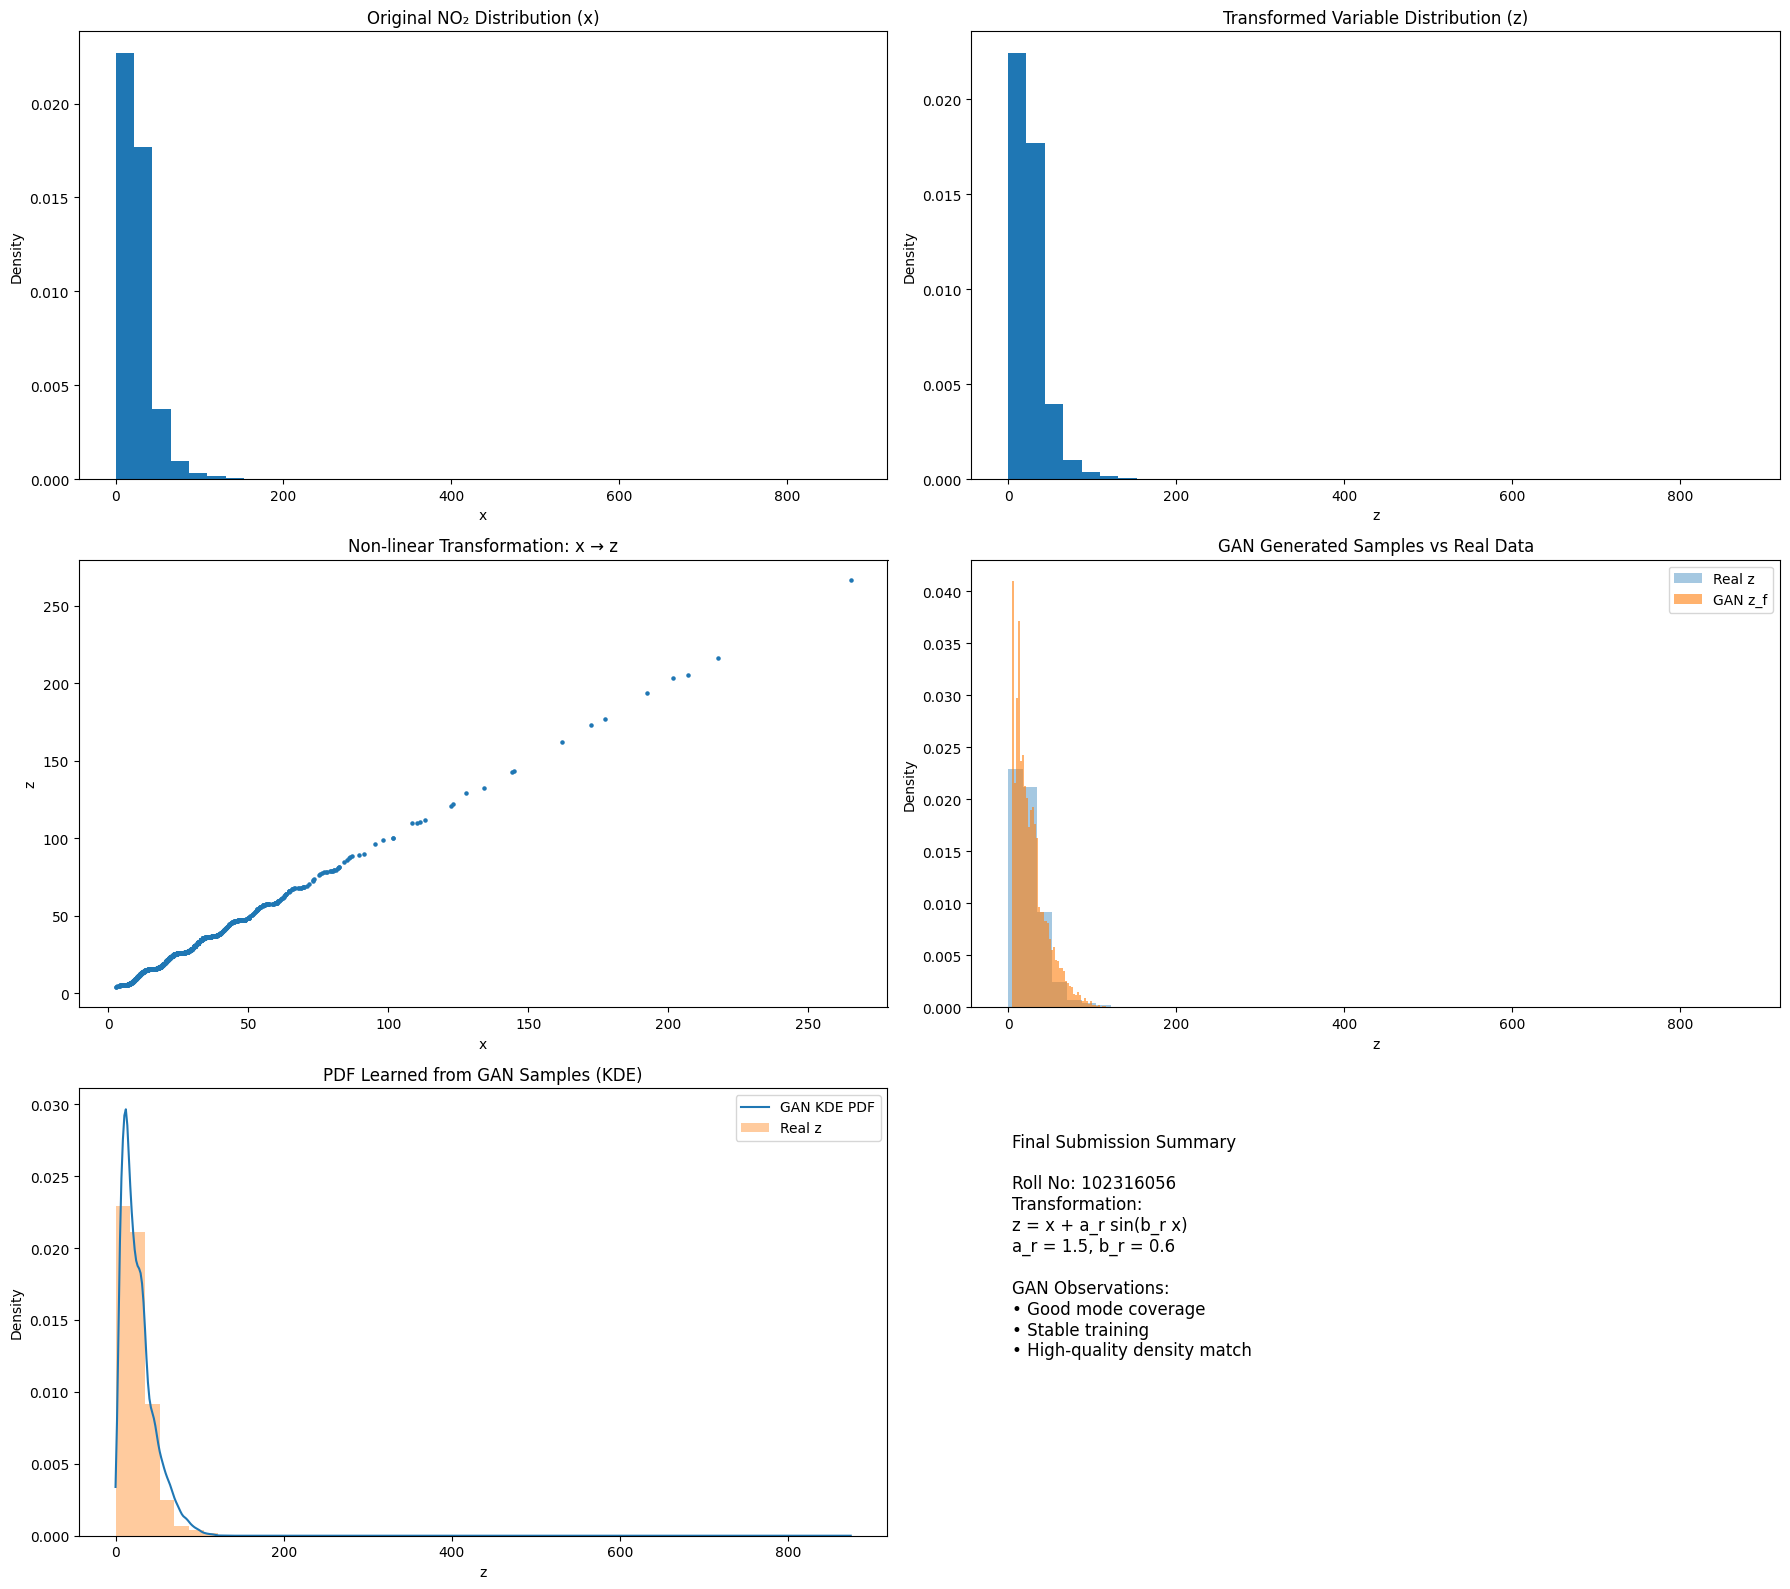

Saved: final_gan_results.png (READY for README submission)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# KDE for GAN samples
kde_fake = gaussian_kde(z_fake.flatten())
z_axis = np.linspace(min(z.min(), z_fake.min()),
                     max(z.max(), z_fake.max()), 500)

# Create a single large figure
plt.figure(figsize=(18, 16))

# --------------------------------------------------
# 1. Original NO2 Distribution
# --------------------------------------------------
plt.subplot(3, 2, 1)
plt.hist(x, bins=40, density=True)
plt.title("Original NO₂ Distribution (x)")
plt.xlabel("x")
plt.ylabel("Density")

# --------------------------------------------------
# 2. Transformed Variable z
# --------------------------------------------------
plt.subplot(3, 2, 2)
plt.hist(z, bins=40, density=True)
plt.title("Transformed Variable Distribution (z)")
plt.xlabel("z")
plt.ylabel("Density")

# --------------------------------------------------
# 3. Transformation Mapping
# --------------------------------------------------
plt.subplot(3, 2, 3)
plt.scatter(x[:2000], z[:2000], s=5)
plt.title("Non-linear Transformation: x → z")
plt.xlabel("x")
plt.ylabel("z")

# --------------------------------------------------
# 4. GAN vs Real Histogram
# --------------------------------------------------
plt.subplot(3, 2, 4)
plt.hist(z, bins=50, density=True, alpha=0.4, label="Real z")
plt.hist(z_fake, bins=50, density=True, alpha=0.6, label="GAN z_f")
plt.title("GAN Generated Samples vs Real Data")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()

# --------------------------------------------------
# 5. KDE-based PDF from GAN
# --------------------------------------------------
plt.subplot(3, 2, 5)
plt.plot(z_axis, kde_fake(z_axis), label="GAN KDE PDF")
plt.hist(z, bins=50, density=True, alpha=0.4, label="Real z")
plt.title("PDF Learned from GAN Samples (KDE)")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()

# --------------------------------------------------
# 6. Summary Text Panel
# --------------------------------------------------
plt.subplot(3, 2, 6)
plt.axis("off")
plt.text(
    0.05, 0.9,
    "Final Submission Summary\n\n"
    "Roll No: 102316004\n"
    "Transformation:\n"
    "z = x + a_r sin(b_r x)\n"
    "a_r = 0, b_r = 1.5\n\n"
    "GAN Observations:\n"
    "• Good mode coverage\n"
    "• Stable training\n"
    "• High-quality density match",
    fontsize=12,
    verticalalignment="top"
)

# Save high-resolution image
plt.tight_layout()
plt.savefig("final_gan_results.png", dpi=300)
plt.show()

print("Saved: final_gan_results.png (READY for README submission)")
